In [1]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2

In [2]:
data = pd.read_csv('../input/covid19-ct-scans/metadata.csv')
data.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [3]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [4]:
# Read sample
sample_ct   = read_nii(data.loc[0,'ct_scan'])
sample_lung = read_nii(data.loc[0,'lung_mask'])
sample_infe = read_nii(data.loc[0,'infection_mask'])
sample_all  = read_nii(data.loc[0,'lung_and_infection_mask'])

In [5]:
# Examine Shape
sample_ct.shape

(512, 512, 301)

In [6]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')

    plt.show()

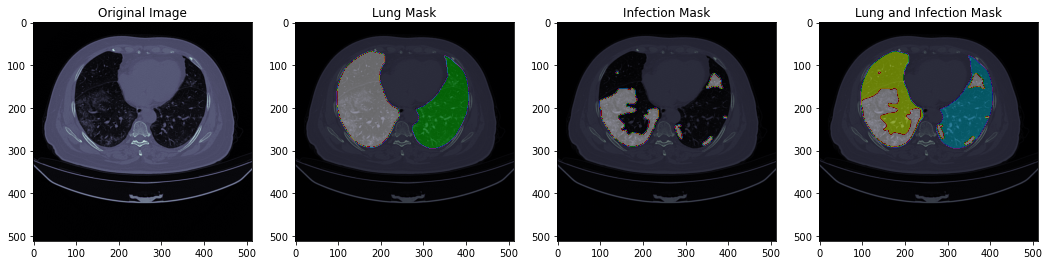

In [7]:
# Examine one slice of a ct scan and its annotations
plot_sample([sample_ct[...,120], sample_lung[...,120], sample_infe[...,120], sample_all[...,120]])


In [8]:
def bulk_plot_sample(array_list, index_list):
    '''
    Plots multiple slices, wrapper of plot_sample
    '''
    for index_value in index_list:
        plot_sample([array_list[0][...,index_value], array_list[1][...,index_value], array_list[2][...,index_value], array_list[3][...,index_value]])


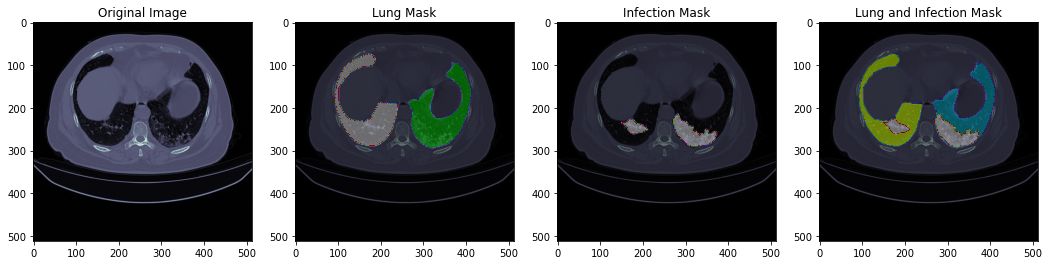

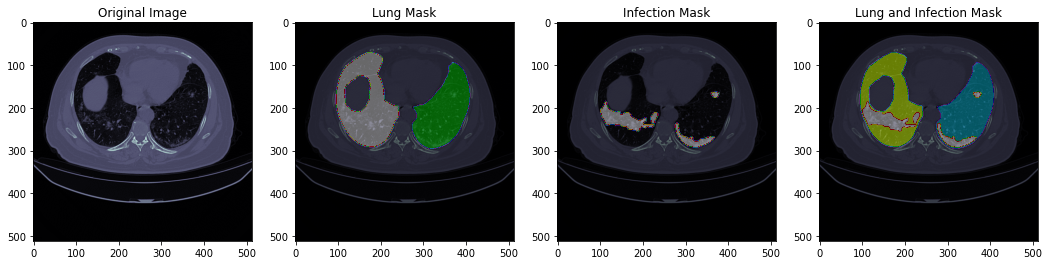

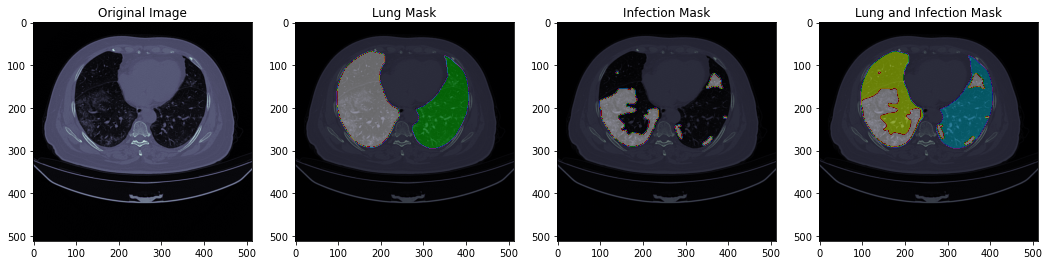

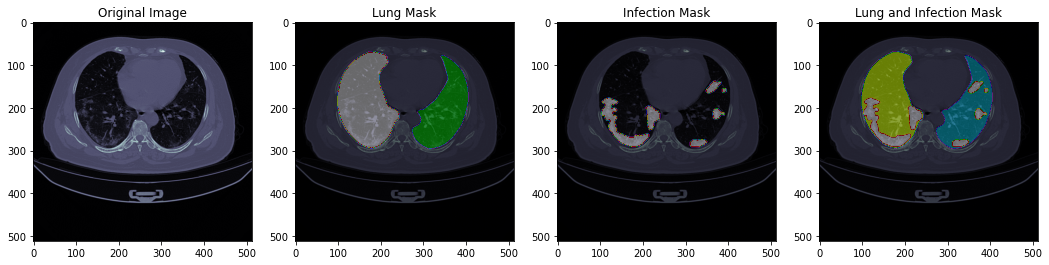

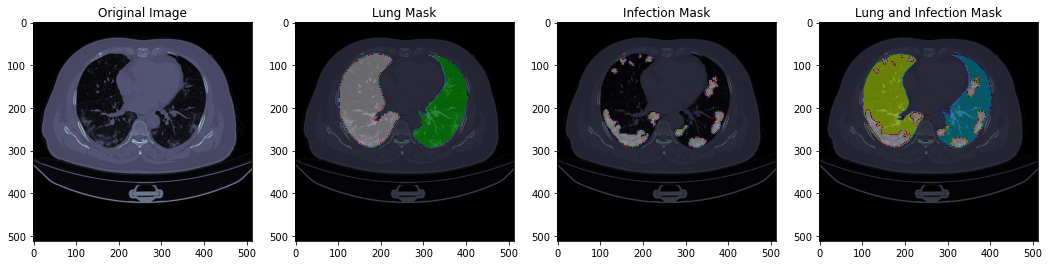

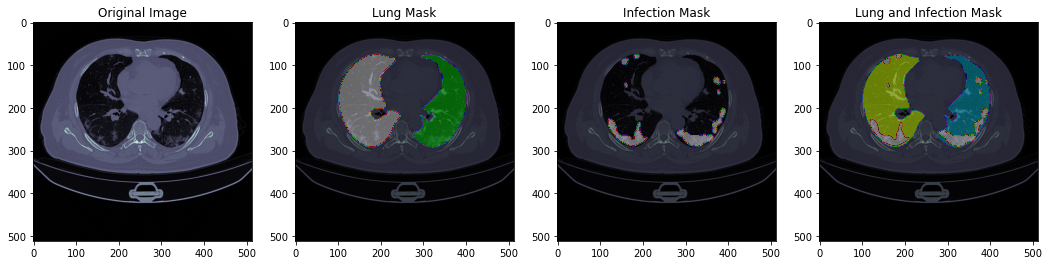

In [9]:
# Examine multiple slices of a ct scan and its annotations
bulk_plot_sample([sample_ct, sample_lung, sample_infe, sample_all], index_list=[100,110,120,130,140,150])

Load Data


In [10]:
lungs = []
infections = []
img_size = 128

for i in range(len(data)):
    ct = read_nii(data['ct_scan'][i])
    infect = read_nii(data['infection_mask'][i])
    
    for ii in range(ct.shape[0]):
        lung_img = cv2.resize(ct[ii], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        infec_img = cv2.resize(infect[ii],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        lungs.append(lung_img[..., np.newaxis])
        infections.append(infec_img[..., np.newaxis])
        

In [11]:
lungs = np.array(lungs)
infections = np.array(infections)

In [12]:
print(lungs.shape)

(11191, 128, 128, 1)


In [13]:
print(infections.shape)

(11191, 128, 128, 1)


In [14]:
from sklearn.model_selection import train_test_split
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size = 0.2)

In [28]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [29]:
def unet(pretrained_weights = None,input_size = (img_size, img_size,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

In [30]:
 model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [31]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [32]:
history = model.fit(lung_train, infect_train, epochs = 10, validation_data = (lung_test, infect_test))

Epoch 1/10
280/280 [==============================] - 15s 53ms/step - loss: 0.6192 - accuracy: 0.9230 - val_loss: 0.0838 - val_accuracy: 0.9931
Epoch 2/10
280/280 [==============================] - 14s 49ms/step - loss: 0.0941 - accuracy: 0.9891 - val_loss: 0.0693 - val_accuracy: 0.9931
Epoch 3/10
280/280 [==============================] - 14s 49ms/step - loss: 0.0654 - accuracy: 0.9905 - val_loss: 0.0377 - val_accuracy: 0.9931
Epoch 4/10
280/280 [==============================] - 14s 49ms/step - loss: 0.0399 - accuracy: 0.9917 - val_loss: 0.0274 - val_accuracy: 0.9931
Epoch 5/10
280/280 [==============================] - 14s 50ms/step - loss: 0.0253 - accuracy: 0.9928 - val_loss: 0.0244 - val_accuracy: 0.9931
Epoch 6/10
280/280 [==============================] - 14s 50ms/step - loss: 0.0220 - accuracy: 0.9929 - val_loss: 0.0228 - val_accuracy: 0.9931
Epoch 7/10
280/280 [==============================] - 14s 49ms/step - loss: 0.0199 - accuracy: 0.9930 - val_loss: 0.0233 - val_accuracy:

In [33]:
model.save('ctscan.h5')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()